# CS418 – Task 3: Engagement Analysis & Anomaly Detection



In [7]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = (12, 6)


VIDEO_DATA_FORMAT = 'json'

VIDEO_DATA_PATH = Path('video_data_fixed.json')
CHANNEL_DATA_PATH = Path('channel_data (1).json')
VIDEO_CATEGORIES_PATH = Path('video_categories.json')

In [8]:
import json
import re
from pathlib import Path

input_path = VIDEO_DATA_PATH
output_path = Path('video_data_fixed.json')

def repair_json_line(line_str: str) -> str:

    fixed_line_chars = []
    in_string = False
    escaped_char = False

    for char in line_str:
        if char == '\\':
            escaped_char = True
            fixed_line_chars.append(char)
        elif char == '"':
            if escaped_char:
                fixed_line_chars.append(char)
                escaped_char = False
            elif in_string:
                fixed_line_chars.append('\\')
                fixed_line_chars.append(char)
                escaped_char = False
            else:
                in_string = not in_string
                fixed_line_chars.append(char)
                escaped_char = False
        else:
            fixed_line_chars.append(char)
            escaped_char = False
    return "".join(fixed_line_chars)


fixed_data = []

print(f"Attempting to fix malformed JSON in '{input_path}'...")
lines_repaired_count = 0
lines_skipped_count = 0

with input_path.open('r', encoding='utf-8') as f_in:
    for i, line in enumerate(f_in):
        try:
            obj = json.loads(line.strip())
            fixed_data.append(obj)
        except json.JSONDecodeError as e:

            repaired_line = repair_json_line(line.strip())
            try:
                obj = json.loads(repaired_line)
                fixed_data.append(obj)
                lines_repaired_count += 1
            except json.JSONDecodeError:
                print(f"Warning: Line {i+1} could not be repaired and will be skipped. Original: {line.strip()[:100]}...")
                lines_skipped_count += 1
                continue

print(f"Processed {i+1} lines. Successfully parsed: {len(fixed_data) - lines_repaired_count}, Repaired: {lines_repaired_count}, Skipped: {lines_skipped_count}.")

if fixed_data:
    with output_path.open('w', encoding='utf-8') as f_out:
        for item in fixed_data:
            json.dump(item, f_out)
            f_out.write('\n')
    print(f"Fixed data saved to '{output_path}'.")
else:
    print("No fixed data to save.")


Attempting to fix malformed JSON in 'video_data_fixed.json'...
Processed 149746 lines. Successfully parsed: 149746, Repaired: 0, Skipped: 0.
Fixed data saved to 'video_data_fixed.json'.


In [9]:
def load_video_data(path: Path, file_format: str) -> pd.DataFrame:
    """Load video-level data from CSV or JSON into a pandas DataFrame."""
    if file_format.lower() == 'csv':
        df = pd.read_csv(path)
    elif file_format.lower() == 'json':

        try:
            with path.open('r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
        except json.JSONDecodeError:

            df = pd.read_json(path, lines=True)
    else:
        raise ValueError("file_format must be 'csv' or 'json'")
    return df


if not VIDEO_DATA_PATH.is_file():
    raise FileNotFoundError(f"Could not find video data at {VIDEO_DATA_PATH!s}. Update VIDEO_DATA_PATH.")

video_df = load_video_data(VIDEO_DATA_PATH, VIDEO_DATA_FORMAT)
print('Video data shape:', video_df.shape)
display(video_df.head())

if not CHANNEL_DATA_PATH.is_file():
    raise FileNotFoundError(f"Could not find channel data at {CHANNEL_DATA_PATH!s}. Update CHANNEL_DATA_PATH.")

with CHANNEL_DATA_PATH.open('r', encoding='utf-8') as f:
    channel_json = json.load(f)
channel_df = pd.DataFrame(channel_json)
print('Channel data shape:', channel_df.shape)
display(channel_df.head())


if not VIDEO_CATEGORIES_PATH.is_file():
    raise FileNotFoundError(f"Could not find category data at {VIDEO_CATEGORIES_PATH!s}. Update VIDEO_CATEGORIES_PATH.")

with VIDEO_CATEGORIES_PATH.open('r', encoding='utf-8') as f:
    categories_json = json.load(f)

items = categories_json.get('items', [])
cat_rows = []
for item in items:
    try:
        cid = int(item['id'])
    except Exception:

        try:
            cid = int(str(item['id']))
        except Exception:
            continue
    cat_rows.append({
        'category_id': cid,
        'category_title': item.get('snippet', {}).get('title')
    })

categories_df = pd.DataFrame(cat_rows)
print('Categories shape:', categories_df.shape)
display(categories_df.head())


Video data shape: (149746, 13)


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror"
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ..."
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,..."


Channel data shape: (1561, 11)


,channel_id,channel_title,description,custom_url,created_at,thumbnail,country,view_count,subscriber_count,hidden_subscribers,video_count
0,UC6sfgGx5u8qCpWeqMxFWpjQ,Crypto Trade1,Cryptotrade1 is basically providing trading si...,@cryptotrade1,2017-11-14T07:12:04Z,https://yt3.ggpht.com/vR-Cl98vUxtqxKOOh9YwDC7_...,AE,32872,1140,false,376
1,UCwQp7Wc1NIKrW4UTOgOmVKg,The Meaning Of Islam,"Assalam Alaikum!\nI’m Ayesha, the creator of “...",@themeaningofislam,2011-10-26T09:33:39Z,https://yt3.ggpht.com/ytc/AGIKgqP8TvqgrQpOpLiT...,AE,88557098,503000,false,121
2,UCZ245tjtaxNCb0Y4i9H9AXQ,Fernando Romero Moreno,Por un Frente Nacional que defienda los valore...,@fernandoromeromoreno1519,2014-07-28T20:45:20Z,https://yt3.ggpht.com/ytc/AGIKgqPe8zceaOY-88SQ...,AR,15661,666,false,47
3,UCNDrlU4YJrjPwO0yB7SG-bg,Ojo de Halcón,None,@ojodehalcon,2017-09-11T03:18:17Z,https://yt3.ggpht.com/ytc/AGIKgqPj3rmRbMVZ_gmt...,AR,28714333,94400,false,3312
4,UCFHAPATvu8q49hy53VPv6SA,Red Internacional de Promotores ODS,Canal Oficial de videos de la Red Internaciona...,@redinternacionaldepromotor7015,2020-02-22T17:10:07.38079Z,https://yt3.ggpht.com/ytc/AGIKgqOnCTiIM6cdyLSV...,AR,103219,5940,false,139


Categories shape: (32, 2)


,category_id,category_title
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports


In [10]:
expected_cols = ['video_id', 'channel_id', 'channel_title', 'category_id',
                 'published_at', 'view_count', 'like_count', 'favorite_count',
                 'comment_count']
missing = [c for c in expected_cols if c not in video_df.columns]
print('Missing columns in video_df:', missing)


numeric_cols = ['view_count', 'like_count', 'favorite_count', 'comment_count']
for col in numeric_cols:
    if col in video_df.columns:
        video_df[col] = pd.to_numeric(video_df[col], errors='coerce')

if 'published_at' in video_df.columns:
    video_df['published_at'] = pd.to_datetime(video_df['published_at'], errors='coerce')
    video_df['published_date'] = video_df['published_at'].dt.date

video_df['like_count'] = video_df['like_count'].fillna(0)
video_df['comment_count'] = video_df['comment_count'].fillna(0)
video_df['favorite_count'] = video_df['favorite_count'].fillna(0)
video_df['view_count'] = video_df['view_count'].fillna(0)

video_df['engagement'] = video_df['like_count'] + video_df['comment_count']
video_df['engagement_rate'] = np.where(
    video_df['view_count'] > 0,
    video_df['engagement'] / video_df['view_count'],
    np.nan
)

if 'category_id' in video_df.columns:
    video_df['category_id'] = pd.to_numeric(video_df['category_id'], errors='coerce')
    video_df = video_df.merge(categories_df, on='category_id', how='left')

print('Video data after feature engineering:')
display(video_df.head())


Missing columns in video_df: []
Video data after feature engineering:


,channel_id,channel_title,video_id,category_id,published_at,title,description,thumbnail,view_count,like_count,favorite_count,comment_count,tags,published_date,engagement,engagement_rate,category_title
0,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,3niQ1dJcqFg,1,2021-08-14 05:51:05+00:00,Los Angeles street art,Taking a look at Los Angeles graffiti and mura...,https://i.ytimg.com/vi/3niQ1dJcqFg/default.jpg,11.0,1.0,0,0.0,NaN,2021-08-14,1.0,0.090909,Film & Animation
1,UCYIvQrhDDhRE8MzS7eRrPsQ,A3,51b-1WotLww,1,2021-08-06 04:17:37+00:00,Los Angeles street art # graffiti # bomber,Taking a look at Los Angeles street art \n@ gr...,https://i.ytimg.com/vi/51b-1WotLww/default.jpg,13.0,2.0,0,0.0,NaN,2021-08-06,2.0,0.153846,Film & Animation
2,UCgOGQK5_1x6GDxvhnOQdqeA,CF,jd2B6rH--tg,1,2021-02-09 20:09:05+00:00,The infinite bicycle,A favorite scene from the movie In The Mouth o...,https://i.ytimg.com/vi/jd2B6rH--tg/default.jpg,15321.0,175.0,0,29.0,"In The Mouth of Madness,John Carpenter,Horror",2021-02-09,204.0,0.013315,Film & Animation
3,UCsEukrAd64fqA7FjwkmZ_Dw,GQ,TRGHIN2PGIA,1,2022-10-05 16:00:12+00:00,Christian Bale Breaks Down His Most Iconic Cha...,Christian Bale breaks down a few of his most i...,https://i.ytimg.com/vi/TRGHIN2PGIA/default.jpg,15569853.0,457300.0,0,18103.0,"american psycho,amsterdam,celebrity,christian ...",2022-10-05,475403.0,0.030534,Film & Animation
4,UCF3qBBXKBFkT6ykYlEZh6Gw,A K,VqDRhf1UpvE,1,2012-03-14 20:21:25+00:00,Smart Card (2005),Smartcard is a story about a man who realizes ...,https://i.ytimg.com/vi/VqDRhf1UpvE/default.jpg,29366.0,293.0,0,29.0,"card,id,identity,technology,future,short film,...",2012-03-14,322.0,0.010965,Film & Animation


In [11]:
if 'published_date' not in video_df.columns:
    raise ValueError('published_date column is missing. Check that published_at was parsed correctly.')

daily_engagement = (
    video_df
    .groupby('published_date')
    .agg(
        total_views=('view_count', 'sum'),
        total_likes=('like_count', 'sum'),
        total_comments=('comment_count', 'sum'),
        video_count=('video_id', 'nunique')
    )
    .sort_index()
)

daily_engagement.index = pd.to_datetime(daily_engagement.index)

mu = daily_engagement['total_views'].mean()
sigma = daily_engagement['total_views'].std(ddof=0)
daily_engagement['views_zscore'] = (daily_engagement['total_views'] - mu) / (sigma if sigma > 0 else 1)

z_threshold = 2.5
daily_engagement['is_anomaly_z'] = daily_engagement['views_zscore'].abs() >= z_threshold

print('Daily engagement (with Z-score anomaly flag):')
display(daily_engagement.head())


Daily engagement (with Z-score anomaly flag):


,total_views,total_likes,total_comments,video_count,views_zscore,is_anomaly_z
published_date,,,,,,
2005-07-08,11629600.0,22683.0,3762.0,1,-0.301825,False
2005-07-16,3948488.0,22371.0,3918.0,1,-0.309148,False
2005-09-19,2916386.0,6450.0,779.0,1,-0.310132,False
2005-10-28,1823910.0,5774.0,595.0,1,-0.311173,False
2005-11-01,1873558.0,3335.0,564.0,1,-0.311126,False


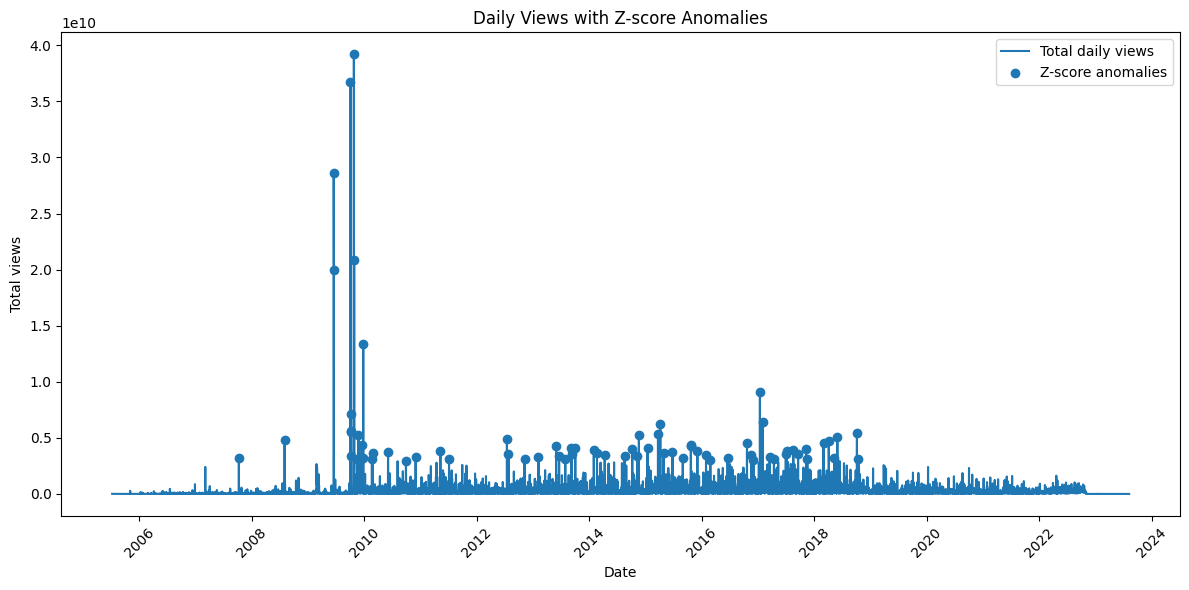

In [12]:
fig, ax = plt.subplots()
ax.plot(daily_engagement.index, daily_engagement['total_views'], label='Total daily views')

anomaly_points = daily_engagement[daily_engagement['is_anomaly_z']]
ax.scatter(anomaly_points.index, anomaly_points['total_views'], marker='o', label='Z-score anomalies')

ax.set_title('Daily Views with Z-score Anomalies')
ax.set_xlabel('Date')
ax.set_ylabel('Total views')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
features_daily = daily_engagement[['total_views', 'total_likes', 'total_comments', 'video_count']].fillna(0)

scaler_daily = StandardScaler()
X_daily = scaler_daily.fit_transform(features_daily)

iso_daily = IsolationForest(
    n_estimators=200,
    contamination=0.03,
    random_state=42,
    n_jobs=-1
)
daily_engagement['iforest_label'] = iso_daily.fit_predict(X_daily)
daily_engagement['is_anomaly_iforest'] = daily_engagement['iforest_label'] == -1

print('Daily engagement with Isolation Forest labels:')
display(daily_engagement.head())

anomalous_days_if = daily_engagement[daily_engagement['is_anomaly_iforest']]
print('Top anomalous days (Isolation Forest):')
display(anomalous_days_if.sort_values('total_views', ascending=False).head(20))


Daily engagement with Isolation Forest labels:


,total_views,total_likes,total_comments,video_count,views_zscore,is_anomaly_z,iforest_label,is_anomaly_iforest
published_date,,,,,,,,
2005-07-08,11629600.0,22683.0,3762.0,1,-0.301825,False,1,False
2005-07-16,3948488.0,22371.0,3918.0,1,-0.309148,False,1,False
2005-09-19,2916386.0,6450.0,779.0,1,-0.310132,False,1,False
2005-10-28,1823910.0,5774.0,595.0,1,-0.311173,False,1,False
2005-11-01,1873558.0,3335.0,564.0,1,-0.311126,False,1,False


Top anomalous days (Isolation Forest):


,total_views,total_likes,total_comments,video_count,views_zscore,is_anomaly_z,iforest_label,is_anomaly_iforest
published_date,,,,,,,,
2009-10-25,3.919806e+10,216045003.0,9293041.0,313,37.056293,True,-1,True
2009-10-03,3.677371e+10,202049788.0,7822716.0,207,34.745055,True,-1,True
2009-06-16,2.859406e+10,171709155.0,6128108.0,157,26.947043,True,-1,True
2009-10-27,2.085995e+10,119830257.0,4038780.0,224,19.573782,True,-1,True
2009-06-17,1.995447e+10,107730416.0,3817104.0,98,18.710546,True,-1,True
2009-12-25,1.333760e+10,73048280.0,2784596.0,71,12.402399,True,-1,True
2017-01-13,9.110507e+09,57369568.0,4355469.0,32,8.372528,True,-1,True
2009-10-07,7.147467e+09,37021822.0,1266483.0,77,6.501077,True,-1,True
2017-01-30,6.418990e+09,33952816.0,1179299.0,31,5.806589,True,-1,True


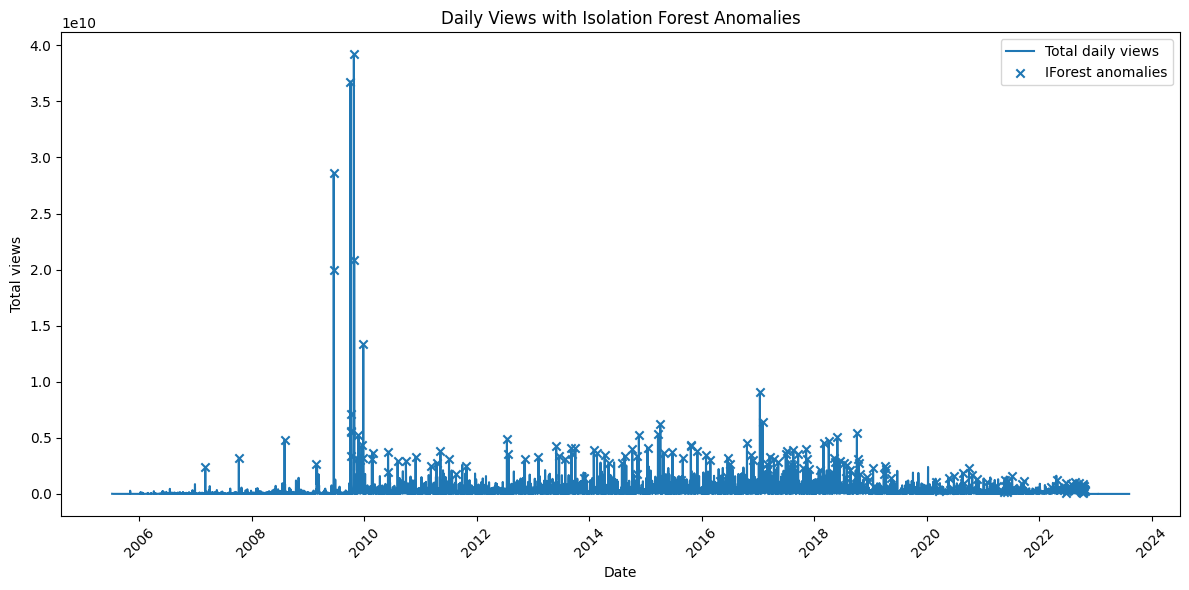

In [14]:
fig, ax = plt.subplots()
ax.plot(daily_engagement.index, daily_engagement['total_views'], label='Total daily views')

anomaly_points_if = daily_engagement[daily_engagement['is_anomaly_iforest']]
ax.scatter(anomaly_points_if.index, anomaly_points_if['total_views'], marker='x', label='IForest anomalies')

ax.set_title('Daily Views with Isolation Forest Anomalies')
ax.set_xlabel('Date')
ax.set_ylabel('Total views')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
channel_group = (
    video_df
    .groupby(['channel_id', 'channel_title'], as_index=False)
    .agg(
        n_videos=('video_id', 'nunique'),
        total_views=('view_count', 'sum'),
        total_likes=('like_count', 'sum'),
        total_comments=('comment_count', 'sum'),
        avg_engagement_rate=('engagement_rate', 'mean')
    )
)
channel_group = channel_group.fillna(0)

features_channel = channel_group[['n_videos', 'total_views', 'total_likes', 'total_comments', 'avg_engagement_rate']]
scaler_channel = StandardScaler()
X_channel = scaler_channel.fit_transform(features_channel)

iso_channel = IsolationForest(
    n_estimators=300,
    contamination=0.05,
    random_state=42,
    n_jobs=-1
)

channel_group['iforest_label'] = iso_channel.fit_predict(X_channel)
channel_group['is_anomalous_channel'] = channel_group['iforest_label'] == -1

print('Channel-level engagement with anomaly flags:')
display(channel_group.head())

anomalous_channels = channel_group[channel_group['is_anomalous_channel']]
print('Top anomalous channels (by total views):')
display(anomalous_channels.sort_values('total_views', ascending=False).head(20))


Channel-level engagement with anomaly flags:


,channel_id,channel_title,n_videos,total_views,total_likes,total_comments,avg_engagement_rate,iforest_label,is_anomalous_channel
0,UC--05sJzdzlpYI4msCyp-ZQ,Julian Faubert,1,2773.0,36.0,4.0,0.014425,1,False
1,UC--0W9cZo-c8mWvg41I2cQg,Lágrimas de Sangre,2,946669.0,8597.0,271.0,0.009415,1,False
2,UC--70ql_IxJmhmqXqrkJrWQ,dakota of earth,1,4206771.0,390935.0,4904.0,0.094096,1,False
3,UC--AV6fpK15tcED_aqer-Cg,まさねこ,1,7236034.0,59760.0,3688.0,0.008768,1,False
4,UC--FRyYJqguhNSklr5o-Vbw,Shanti Shivani Music Sound Yoga,1,97.0,4.0,0.0,0.041237,1,False


Top anomalous channels (by total views):


,channel_id,channel_title,n_videos,total_views,total_likes,total_comments,avg_engagement_rate,iforest_label,is_anomalous_channel
24548,UCHkj014U2CQ2Nv0UZeYpE_A,JustinBieberVEVO,40,2.169594e+10,156088559.0,12284780.0,0.012781,-1,True
1583,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,30,2.089265e+10,116286605.0,3441769.0,0.011794,-1,True
201,UC-8Q-hLdECwQmaWNwXitYDw,KatyPerryVEVO,26,2.051899e+10,105814772.0,5769310.0,0.010323,-1,True
14838,UCANLZYMidaCbLQFWXBC95Jg,TaylorSwiftVEVO,44,1.939382e+10,136993511.0,6754435.0,0.014286,-1,True
5117,UC2xskkQVFEpLcGFnNSLQY0A,RihannaVEVO,39,1.721198e+10,84496123.0,3379118.0,0.007664,-1,True
3937,UC20vb-R_px4CguHzzBPhoyQ,EminemVEVO,35,1.709072e+10,135400959.0,6531924.0,0.014142,-1,True
23339,UCGnjeahCJW1AF34HBmQTJ-Q,shakiraVEVO,27,1.638414e+10,83183952.0,3897401.0,0.006516,-1,True
5585,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,105,1.620302e+10,464694542.0,83677901.0,0.105788,-1,True
67738,UCoUM-UJ7rirJYP8CQ0EIaHA,Bruno Mars,20,1.579860e+10,92443066.0,3035789.0,0.007899,-1,True
31213,UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,21,1.554387e+10,82549664.0,2359339.0,0.005787,-1,True


/tmp/ipython-input-342765670.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_channels['channel_title'], rotation=90)


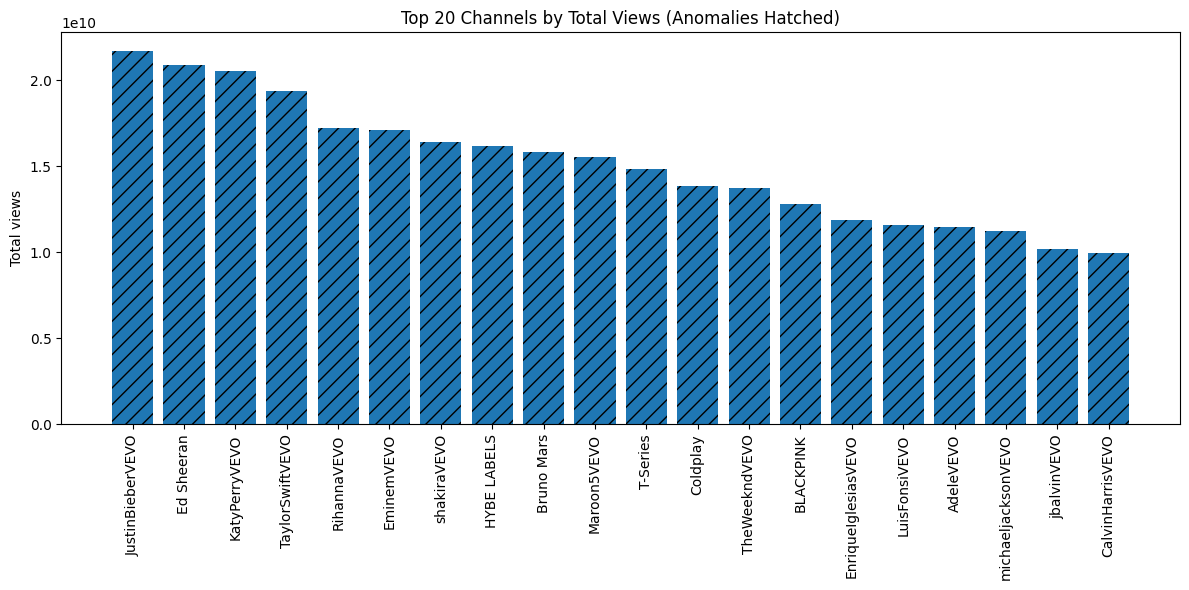

In [16]:
top_channels = channel_group.sort_values('total_views', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(top_channels['channel_title'], top_channels['total_views'])
for bar, is_anom in zip(bars, top_channels['is_anomalous_channel']):
    if is_anom:
        bar.set_hatch('//')

ax.set_title('Top 20 Channels by Total Views (Anomalies Hatched)')
ax.set_ylabel('Total views')
ax.set_xticklabels(top_channels['channel_title'], rotation=90)
plt.tight_layout()
plt.show()


In [21]:
category_views = video_df.groupby('category_title')['view_count'].sum().sort_values(ascending=False)
top_10_categories = category_views.head(10)

print('Top 10 Video Categories by Total Views:')
display(top_10_categories)

Top 10 Video Categories by Total Views:


,view_count
category_title,
Music,1.877517e+12
Entertainment,1.387596e+11
Education,7.673620e+10
People & Blogs,7.494660e+10
Film & Animation,4.675986e+10
News & Politics,3.985870e+10
Comedy,2.496816e+10
Sports,1.690980e+10
Science & Technology,1.531806e+10


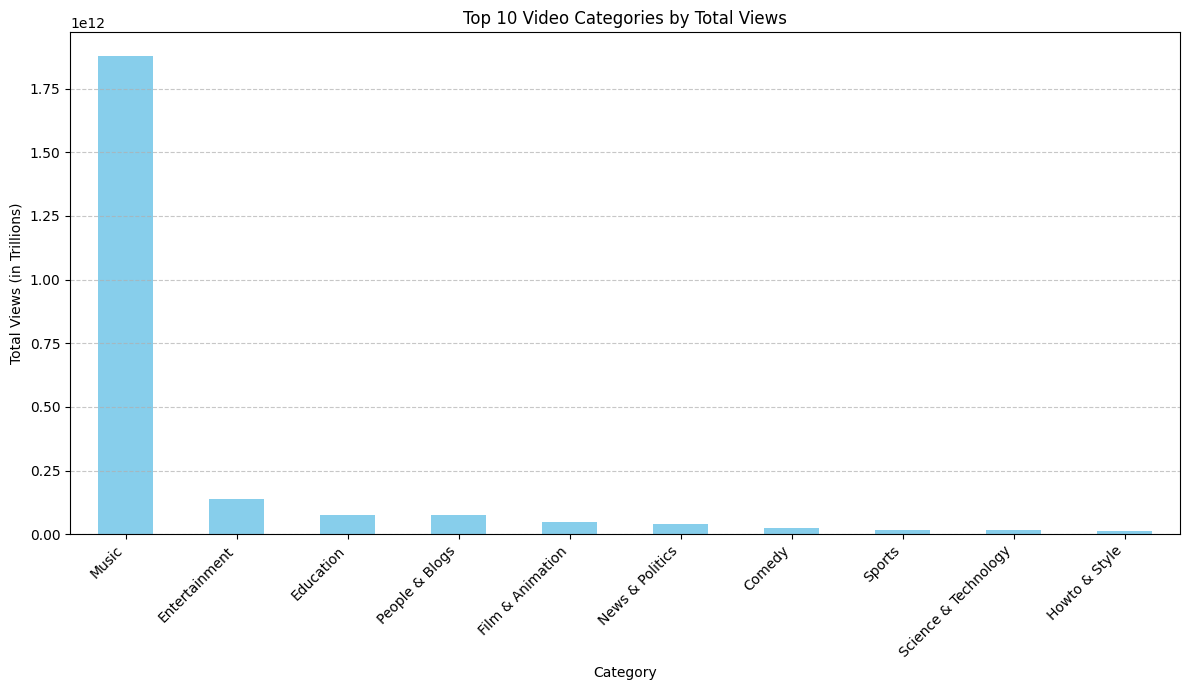

In [22]:
plt.figure(figsize=(12, 7))
top_10_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 Video Categories by Total Views')
plt.xlabel('Category')
plt.ylabel('Total Views (in Trillions)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Top 10 Video Categories by Average Engagement Rate:


,engagement_rate
category_title,
Gaming,0.096589
Entertainment,0.063950
People & Blogs,0.063268
Pets & Animals,0.062940
News & Politics,0.056766
Comedy,0.055382
Education,0.055033
Howto & Style,0.050742
Nonprofits & Activism,0.049419


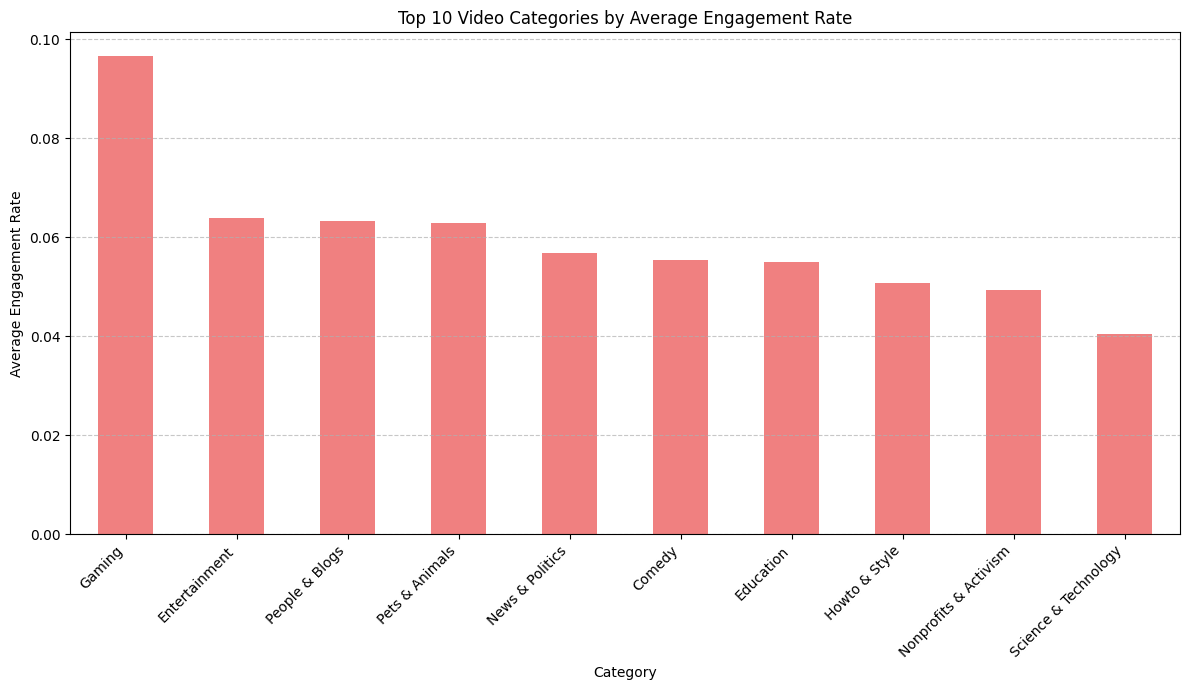

In [23]:
category_engagement = video_df.groupby('category_title')['engagement_rate'].mean().sort_values(ascending=False)
top_10_engagement_categories = category_engagement.head(10)

print('Top 10 Video Categories by Average Engagement Rate:')
display(top_10_engagement_categories)

plt.figure(figsize=(12, 7))
top_10_engagement_categories.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Video Categories by Average Engagement Rate')
plt.xlabel('Category')
plt.ylabel('Average Engagement Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Reasoning**:
The next step is to calculate the average engagement rate for the top 20 channels and visualize them, as specified in the main task. This involves grouping the `video_df` by channel, calculating the mean engagement rate, and then plotting the top 20.



Top 20 Channels by Average Engagement Rate:


,,engagement_rate
channel_id,channel_title,
UCPgWWlvrASB0PxlMeHNMpuQ,Willian Limmah,25.186667
UC19g-GmSWU_BLkiWsEZxkKw,SmilesOne,25.141304
UCq-26KBoE_vwxnKaCLE5o8w,Victor Gomes,22.529412
UCQN_BKM_o7CmghxVCGGev2w,Bezzer,22.308642
UC6DbBeaXrs2R-ezvnzFlkSg,ComandoGMZ,20.524752
UCyPoinz7PjRpjFttVb8H46g,Thesilentweapon Games,18.402299
UCKNONFzl1UC8MYRa43fVtig,Yovo,17.383929
UC6s1AYXQHpCtQ9OoJgq-fNQ,Jovens Geeks,15.533333
UCP6NgEehzERiTLH9hG1dGDg,Gustavando,15.299401


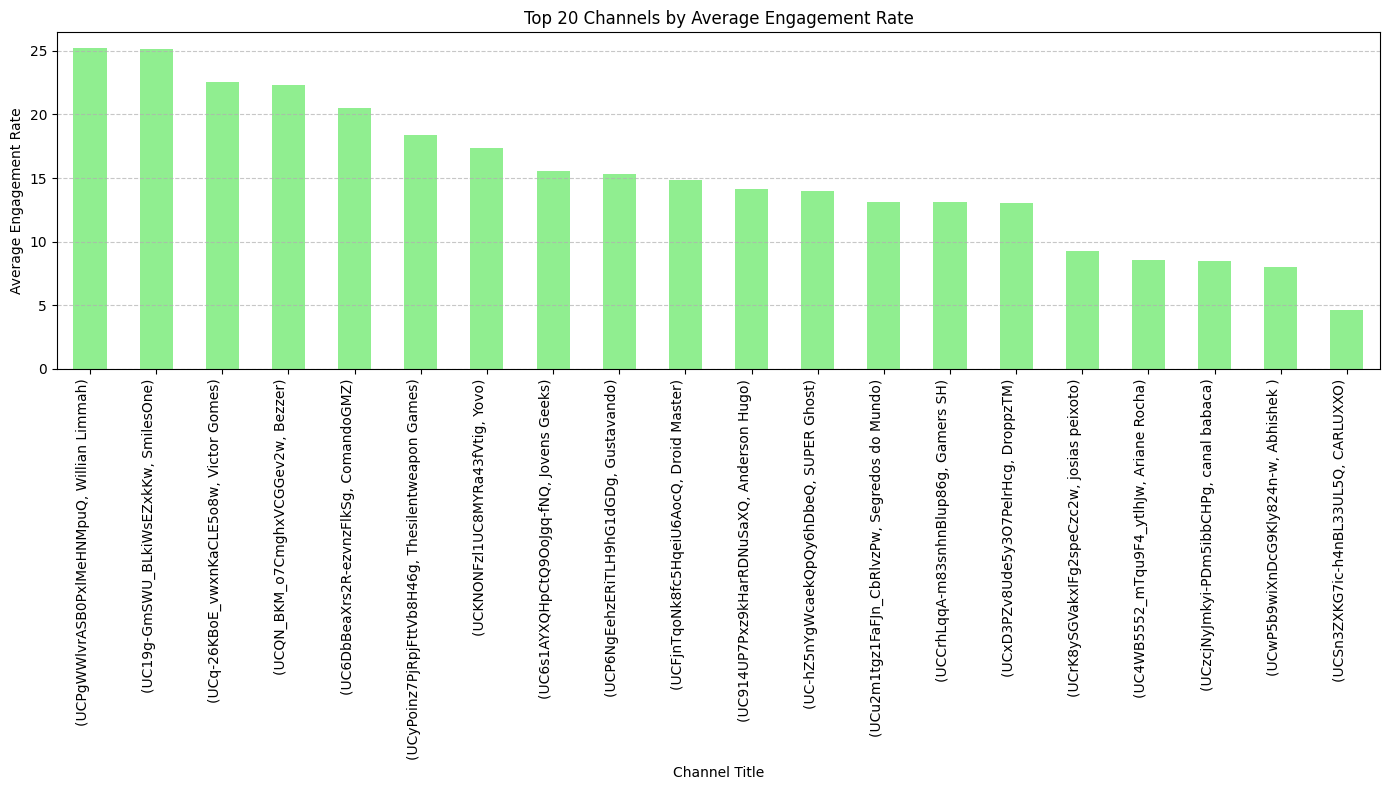

In [24]:
channel_engagement = video_df.groupby(['channel_id', 'channel_title'])['engagement_rate'].mean().sort_values(ascending=False)
top_20_engagement_channels = channel_engagement.head(20)

print('Top 20 Channels by Average Engagement Rate:')
display(top_20_engagement_channels)

plt.figure(figsize=(14, 8))
top_20_engagement_channels.plot(kind='bar', color='lightgreen')
plt.title('Top 20 Channels by Average Engagement Rate')
plt.xlabel('Channel Title')
plt.ylabel('Average Engagement Rate')
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

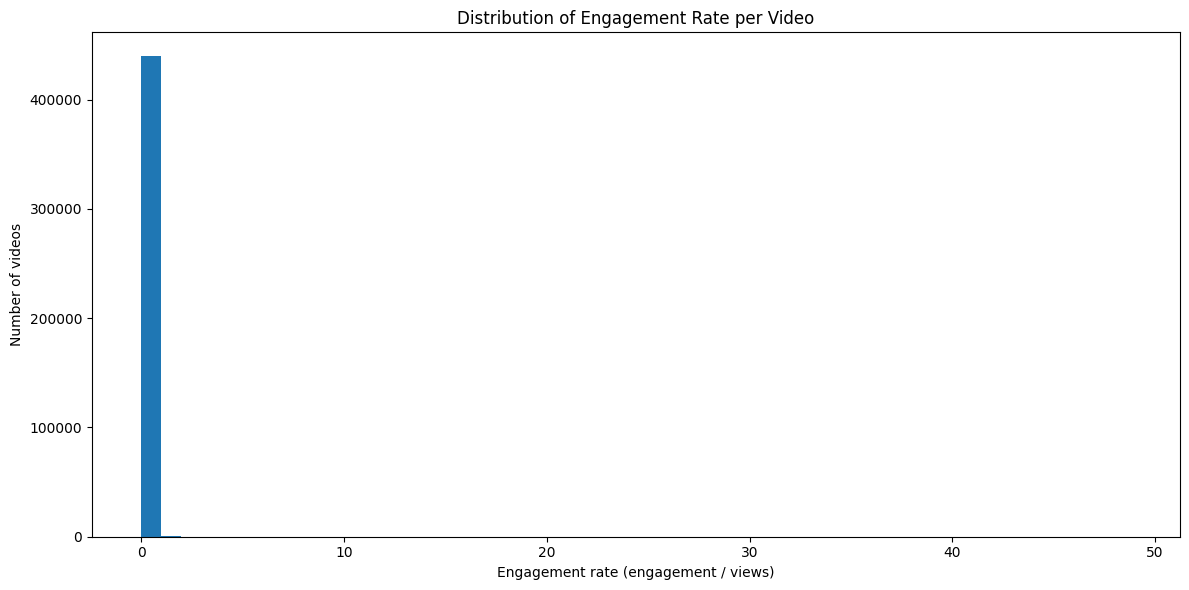

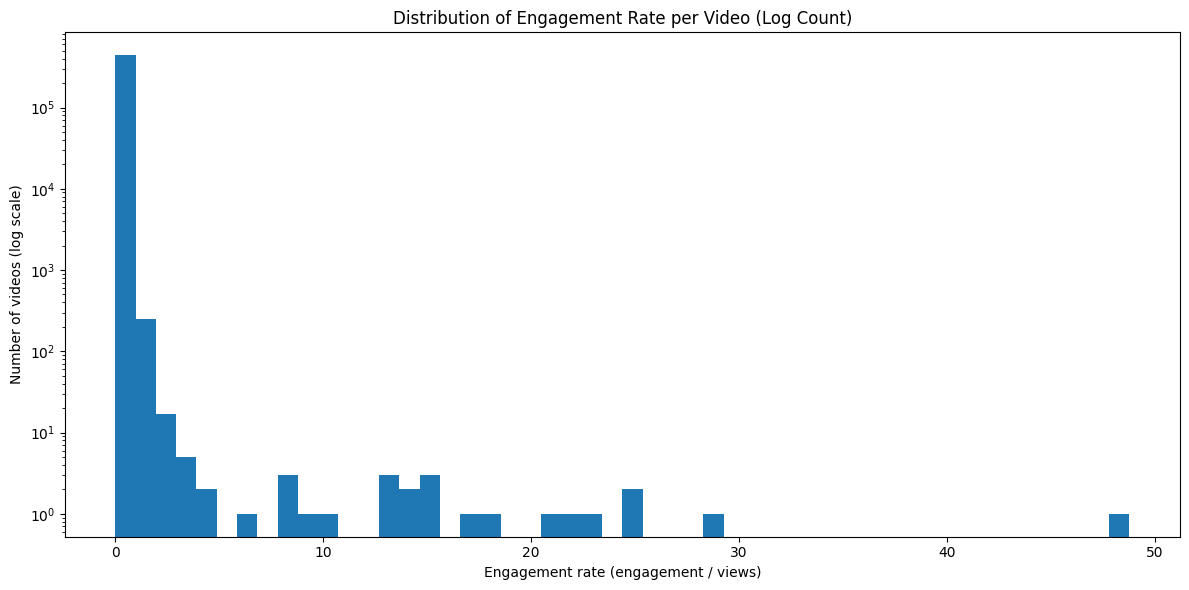

In [27]:
import numpy as np
import matplotlib.pyplot as plt

eng_rate = video_df['engagement_rate'].replace([np.inf, -np.inf], np.nan).dropna()

fig, ax = plt.subplots()
ax.hist(eng_rate, bins=50)
ax.set_title('Distribution of Engagement Rate per Video')
ax.set_xlabel('Engagement rate (engagement / views)')
ax.set_ylabel('Number of videos')
plt.tight_layout()
plt.show()


fig, ax = plt.subplots()
ax.hist(eng_rate, bins=50, log=True)
ax.set_title('Distribution of Engagement Rate per Video (Log Count)')
ax.set_xlabel('Engagement rate (engagement / views)')
ax.set_ylabel('Number of videos (log scale)')
plt.tight_layout()
plt.show()


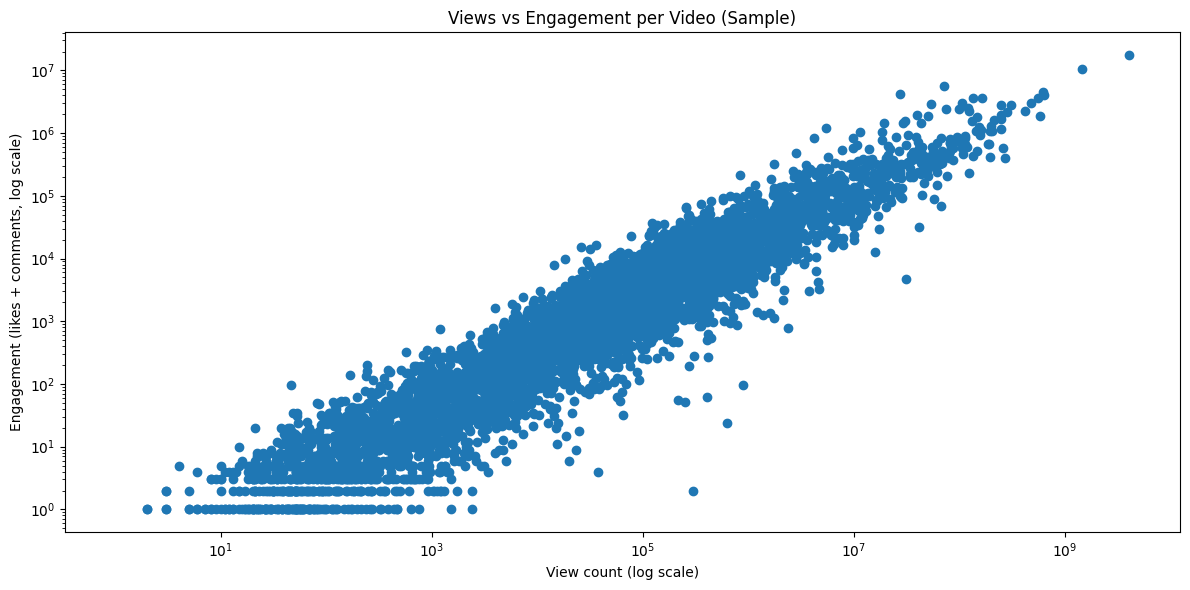

In [28]:

sample = video_df.sample(min(5000, len(video_df)), random_state=42)

fig, ax = plt.subplots()
scatter = ax.scatter(
    sample['view_count'],
    sample['engagement'],
)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Views vs Engagement per Video (Sample)')
ax.set_xlabel('View count (log scale)')
ax.set_ylabel('Engagement (likes + comments, log scale)')
plt.tight_layout()
plt.show()


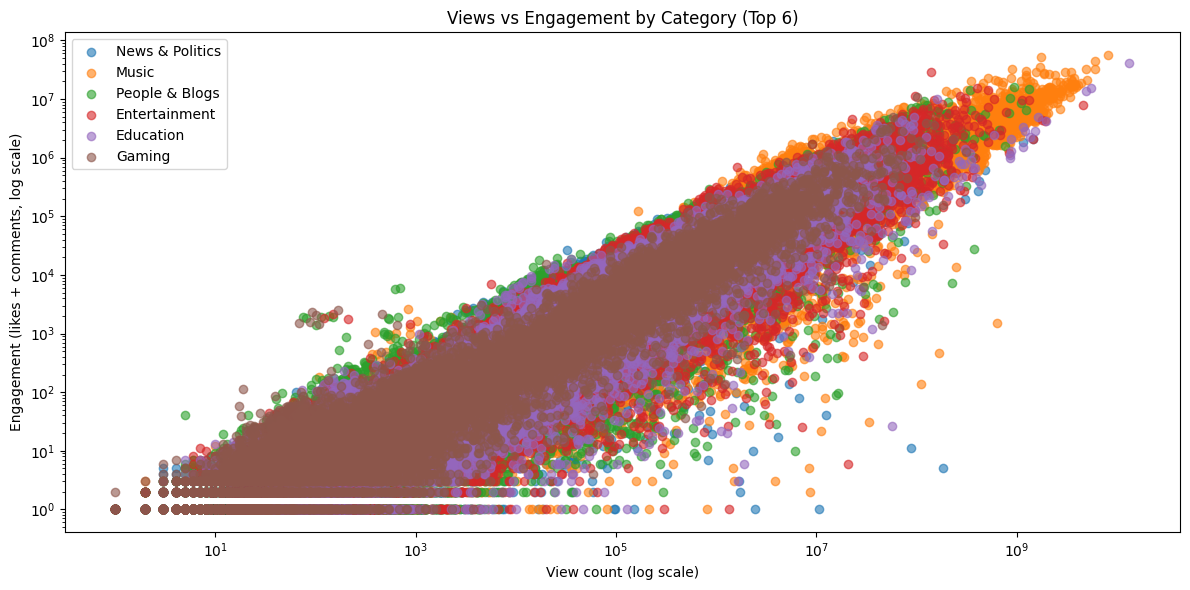

In [29]:
top_cats = (
    video_df['category_title']
    .value_counts()
    .head(6)
    .index
)

subset = video_df[video_df['category_title'].isin(top_cats)].copy()

fig, ax = plt.subplots()
for cat in top_cats:
    df_cat = subset[subset['category_title'] == cat]
    ax.scatter(
        df_cat['view_count'],
        df_cat['engagement'],
        label=str(cat),
        alpha=0.6,
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Views vs Engagement by Category (Top 6)')
ax.set_xlabel('View count (log scale)')
ax.set_ylabel('Engagement (likes + comments, log scale)')
ax.legend()
plt.tight_layout()
plt.show()


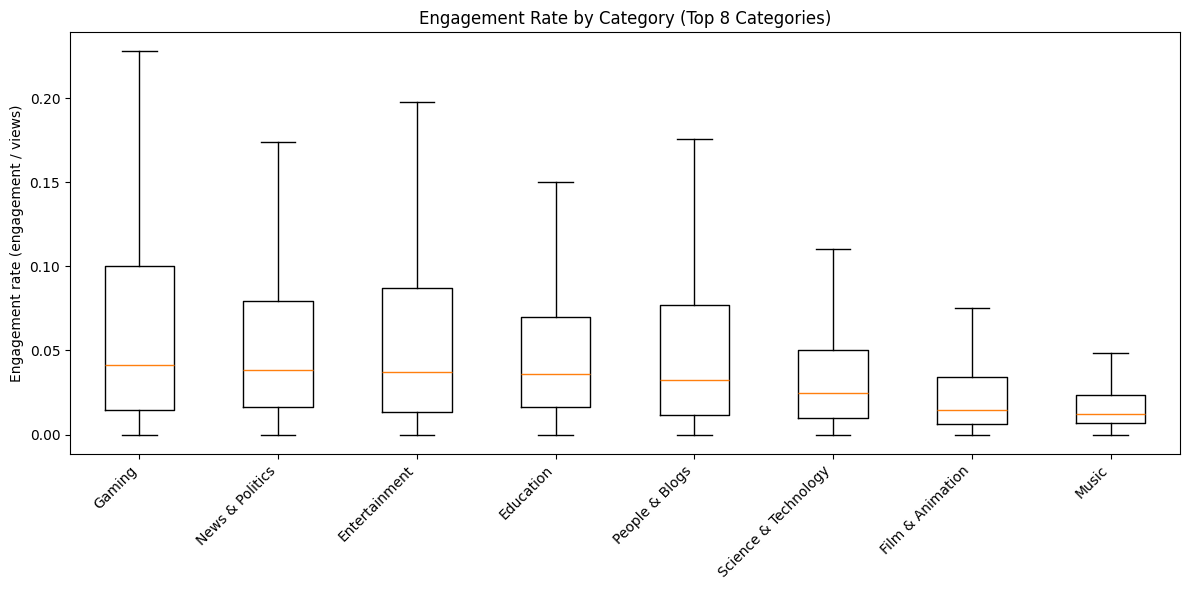

In [30]:
top_cat_titles = (
    video_df['category_title']
    .value_counts()
    .head(8)
    .index
)

box_df = video_df[
    video_df['category_title'].isin(top_cat_titles)
].copy()

box_df['engagement_rate'] = box_df['engagement_rate'].replace([np.inf, -np.inf], np.nan)
box_df = box_df.dropna(subset=['engagement_rate'])

order = (
    box_df.groupby('category_title')['engagement_rate']
    .median()
    .sort_values(ascending=False)
    .index
)

fig, ax = plt.subplots(figsize=(12, 6))
box_data = [box_df[box_df['category_title'] == cat]['engagement_rate'] for cat in order]
ax.boxplot(box_data, showfliers=False)
ax.set_xticks(range(1, len(order)+1))
ax.set_xticklabels(order, rotation=45, ha='right')
ax.set_title('Engagement Rate by Category (Top 8 Categories)')
ax.set_ylabel('Engagement rate (engagement / views)')
plt.tight_layout()
plt.show()


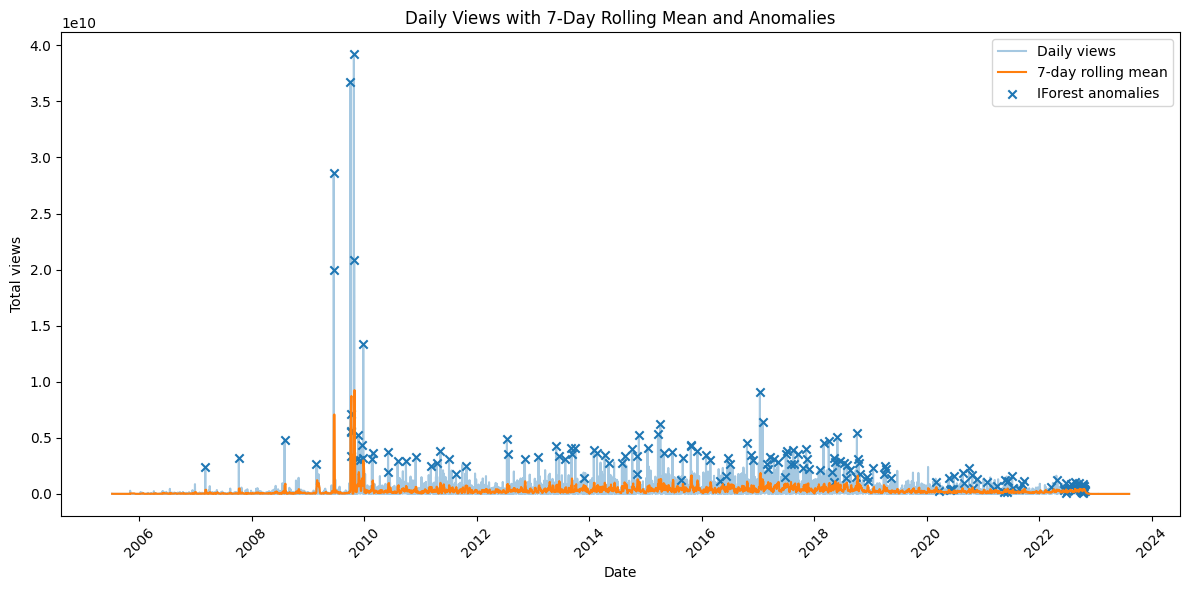

In [31]:
daily_eng_plot = daily_engagement.copy()
daily_eng_plot = daily_eng_plot.sort_index()
daily_eng_plot['views_7d_roll'] = daily_eng_plot['total_views'].rolling(window=7, min_periods=1).mean()

fig, ax = plt.subplots()
ax.plot(daily_eng_plot.index, daily_eng_plot['total_views'], label='Daily views', alpha=0.4)
ax.plot(daily_eng_plot.index, daily_eng_plot['views_7d_roll'], label='7-day rolling mean')

anom = daily_eng_plot[daily_eng_plot['is_anomaly_iforest']]
ax.scatter(anom.index, anom['total_views'], marker='x', label='IForest anomalies')

ax.set_title('Daily Views with 7-Day Rolling Mean and Anomalies')
ax.set_xlabel('Date')
ax.set_ylabel('Total views')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


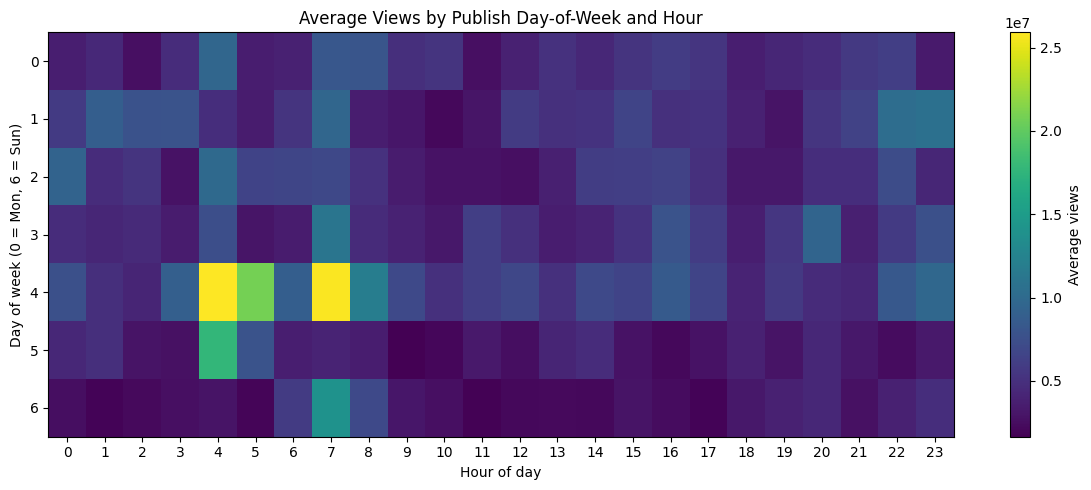

In [32]:

video_df['published_at'] = pd.to_datetime(video_df['published_at'], errors='coerce')

video_df['dow'] = video_df['published_at'].dt.dayofweek
video_df['hour'] = video_df['published_at'].dt.hour
heat = (
    video_df
    .groupby(['dow', 'hour'])
    .agg(avg_views=('view_count', 'mean'))
    .reset_index()
)

heat_pivot = heat.pivot(index='dow', columns='hour', values='avg_views').fillna(0)

fig, ax = plt.subplots(figsize=(12, 5))
cax = ax.imshow(heat_pivot, aspect='auto', interpolation='nearest')

ax.set_title('Average Views by Publish Day-of-Week and Hour')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Day of week (0 = Mon, 6 = Sun)')
ax.set_xticks(range(24))
ax.set_yticks(range(7))
fig.colorbar(cax, ax=ax, label='Average views')
plt.tight_layout()
plt.show()


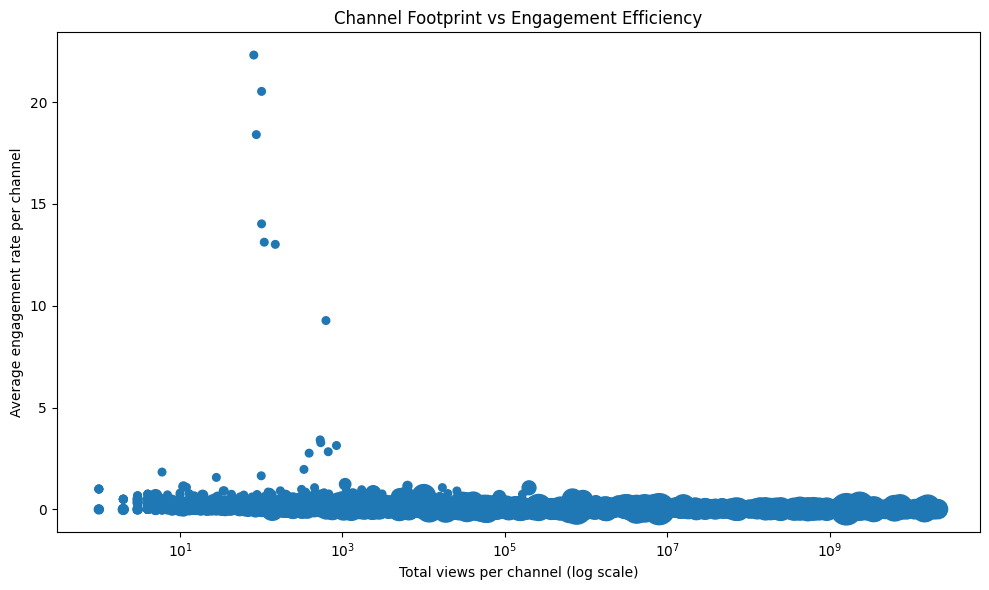

In [33]:

cg = channel_group.copy()
cg['avg_engagement_per_video'] = np.where(
    cg['n_videos'] > 0,
    cg['total_likes'] + cg['total_comments'] / cg['n_videos'],
    0
)

fig, ax = plt.subplots(figsize=(10, 6))
sizes = np.sqrt(cg['n_videos']) * 30

scatter = ax.scatter(
    cg['total_views'],
    cg['avg_engagement_rate'],
    s=sizes,
)
ax.set_xscale('log')

ax.set_title('Channel Footprint vs Engagement Efficiency')
ax.set_xlabel('Total views per channel (log scale)')
ax.set_ylabel('Average engagement rate per channel')
plt.tight_layout()
plt.show()


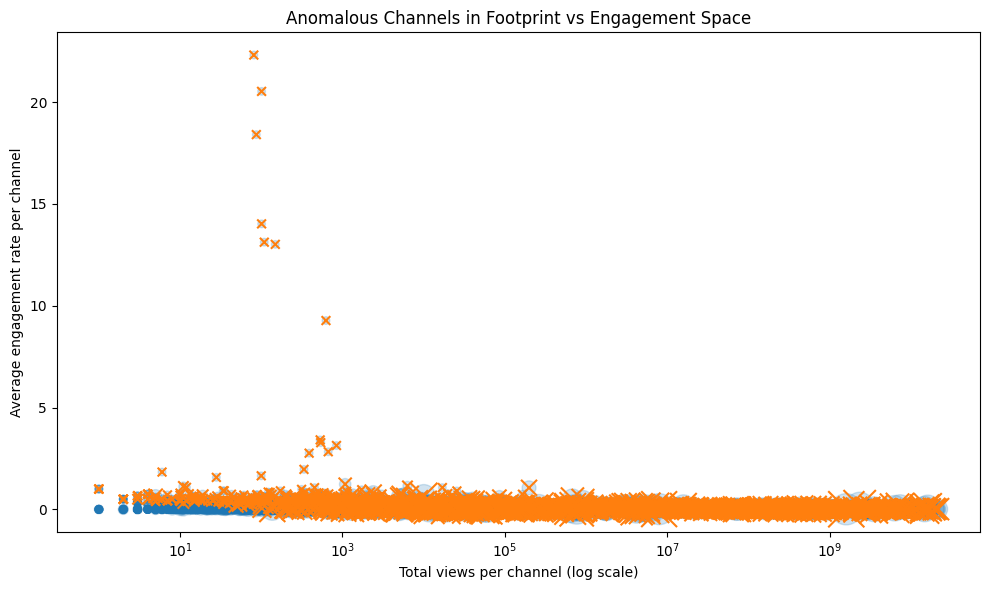

In [34]:
anom_c = cg[cg['is_anomalous_channel']]

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    cg['total_views'],
    cg['avg_engagement_rate'],
    s=sizes,
    alpha=0.2,
)

ax.scatter(
    anom_c['total_views'],
    anom_c['avg_engagement_rate'],
    s=np.sqrt(anom_c['n_videos']) * 40,
    marker='x',
)

ax.set_xscale('log')
ax.set_title('Anomalous Channels in Footprint vs Engagement Space')
ax.set_xlabel('Total views per channel (log scale)')
ax.set_ylabel('Average engagement rate per channel')
plt.tight_layout()
plt.show()
